In [5]:
import os
import glob
import cv2
import numpy as np
import random
import json
import matplotlib.pyplot as plt
from create_dataset_utils import *
import torch
from PIL import Image

Tạo dataset

In [ ]:

vid_folder = r'C:\Users\phann\Documents\Pig_farming\dataset\2019-11-22--11_20_15'
track_folder = r'C:\Users\phann\Documents\Pig_farming\dataset\results_dataset\2019-11-22--11_20_15'
output_dir = r'output_frame/55'
scale_factor = 0.55  # Set to None to skip padding

# Create output directories
images_output_dir = os.path.join(output_dir, "images")
density_maps_output_dir = os.path.join(output_dir, "gt_density_maps")
os.makedirs(images_output_dir, exist_ok=True)
os.makedirs(density_maps_output_dir, exist_ok=True)

# check dataset img_id
existing_images = glob.glob(os.path.join(images_output_dir, "*.jpg"))
if existing_images:
    existing_numbers = []
    for file in existing_images:
        basename = os.path.basename(file) 
        number_str = os.path.splitext(basename)[0]  
        try:
            num = int(number_str)
            existing_numbers.append(num)
        except ValueError:
            pass
    if existing_numbers:
        global_frame_counter = max(existing_numbers) + 1
    else:
        global_frame_counter = 1
else:
    global_frame_counter = 1

video_dirs = sorted(glob.glob(os.path.join(vid_folder, "*")))
annotations = {}

for video in video_dirs:
    video_files = glob.glob(os.path.join(video, "color.mp4"))
    video_id = os.path.basename(video)
    if not video_files:
        print(f"No video file found in {video}")
        continue
    video_file = video_files[0]
    
    matching_track_dir = os.path.join(track_folder, video_id)
    if not os.path.exists(matching_track_dir):
        print(f"No matching track folder for video folder {video_id}")
        continue
    track_files = glob.glob(os.path.join(matching_track_dir, "behaviour_15.npy"))
    if not track_files:
        print(f"No track files found in {matching_track_dir}")
        continue
    track_file = track_files[0]
    
    global_frame_counter, annotations = create_dataset(
        video_file, track_file, images_output_dir, density_maps_output_dir,
        annotations, video_id, global_frame_counter, scale_factor
    )

annotation_file = os.path.join(output_dir, "annotation.json")
with open(annotation_file, 'w') as f:
    json.dump(annotations, f, indent=4)

print('All done!')

Processed frame 791 from video 000000 (video frame id: 0)
Processed frame 792 from video 000000 (video frame id: 199)
Processed frame 793 from video 000000 (video frame id: 399)
Processed frame 794 from video 000000 (video frame id: 599)
Processed frame 795 from video 000000 (video frame id: 799)
Processed frame 796 from video 000000 (video frame id: 999)
Processed frame 797 from video 000000 (video frame id: 1199)
Processed frame 798 from video 000000 (video frame id: 1399)
Processed frame 799 from video 000000 (video frame id: 1599)
Processed frame 800 from video 000000 (video frame id: 1799)
Processed frame 801 from video 000001 (video frame id: 0)
Processed frame 802 from video 000001 (video frame id: 199)
Processed frame 803 from video 000001 (video frame id: 399)
Processed frame 804 from video 000001 (video frame id: 599)
Processed frame 805 from video 000001 (video frame id: 799)
Processed frame 806 from video 000001 (video frame id: 999)
Processed frame 807 from video 000001 (v

Tạo file json train_val_test spilt

In [6]:
output_dir = r'output_frame/55'
os.makedirs(output_dir, exist_ok=True)
create_data_split(images_output_dir, output_dir)

Data split saved to output_frame/55\data_split.json


Kiểm tra Dataset

Density map shape: (720, 1280), Sum: 8.000000953674316


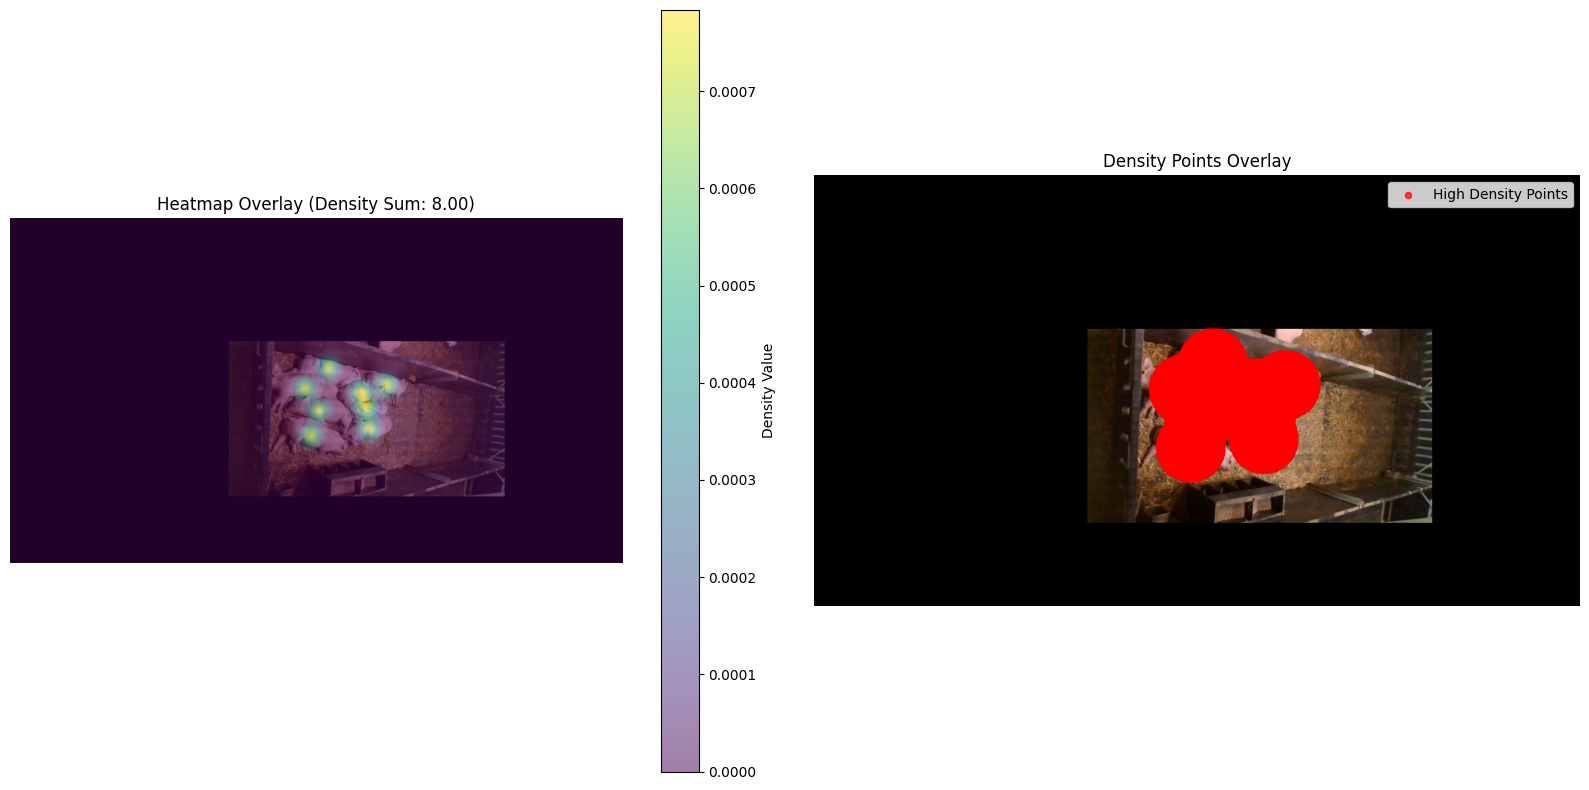

Overlay visualization saved as 'density_overlay_combined.png'


In [ ]:
#load density map
density_path = r'C:\Users\phann\Documents\Pig_farming\LearningToCountEverything\output_frame\45\gt_density_maps\1.npy'
density = np.load(density_path).astype('float32')

if density is None or density.size == 0:
    print("Error: Loaded density map is empty!")
else:
    print(f"Density map shape: {density.shape}, Sum: {density.sum()}")

density_tensor = torch.tensor(density, dtype=torch.float32)

#load image
real_image_path = r'C:\Users\phann\Documents\Pig_farming\LearningToCountEverything\output_frame\45\images\1.jpg'
real_image = plt.imread(real_image_path)

# kiểm tra size
if real_image.shape[:2] != density.shape:
    print("Warning: Real image and density map dimensions do not match. Resizing density map to match real image dimensions.")
    # Convert density to a PIL image and resize it
    density_img = Image.fromarray(density)
    density_resized = np.array(density_img.resize((real_image.shape[1], real_image.shape[0]), Image.BILINEAR))
else:
    density_resized = density

#Visual 
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# 1. Heatmap Overlay
ax[0].imshow(real_image, cmap='gray')
heatmap = ax[0].imshow(density_resized, cmap='viridis', alpha=0.5)
fig.colorbar(heatmap, ax=ax[0], label="Density Value")
ax[0].set_title(f"Heatmap Overlay (Density Sum: {density_tensor.sum():.2f})")
ax[0].axis('off')

# 2. Density Points Overlay
threshold = np.percentile(density_resized, 95)
points = np.argwhere(density_resized > threshold)
x_coords = points[:, 1]
y_coords = points[:, 0]
ax[1].imshow(real_image, cmap='gray')
ax[1].scatter(x_coords, y_coords, color='red', s=20, alpha=0.7, label='High Density Points')
ax[1].set_title("Density Points Overlay")
ax[1].legend()
ax[1].axis('off')

plt.tight_layout()
plt.savefig("density_overlay_combined.png", dpi=300, bbox_inches='tight')
plt.show()

print("Overlay visualization saved as 'density_overlay_combined.png'")
